In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, confusion_matrix, classification_report, roc_curve, auc
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

plt.rc('font', family='NanumBarunGothic')


# 미션 1: 교육 프로그램의 학습 효과 분석 보고서

In [2]:
np.random.seed(321)
n_students = 150
control_scores = np.random.normal(65, 10, n_students)
smartlearn_scores = np.random.normal(70, 12, n_students)
education_data = pd.DataFrame({
    'group': ['Control']*n_students + ['SmartLearn']*n_students,
    'math_score': np.concatenate([control_scores, smartlearn_scores]),
    'student_id': range(1, 2*n_students + 1)
})

print("📚 교육 프로그램 데이터 미리보기")
print(education_data.groupby('group')['math_score'].agg(['count', 'mean', 'std']).round(2))


📚 교육 프로그램 데이터 미리보기
            count   mean    std
group                          
Control       150  64.93   9.67
SmartLearn    150  70.47  11.29


### 1. 기본 통계량 비교

In [17]:
control_mean = education_data[education_data['group'] == 'Control']['math_score'].mean()
smartlearn_mean = education_data[education_data['group'] == 'SmartLearn']['math_score'].mean()
control_se = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_se = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()

print(f"대조군 수학 점수: {control_mean:.2f} ± {control_se:.2f}")
print(f"SmartLearn 수학 점수: {smartlearn_mean:.2f} ± {smartlearn_se:.2f}")
print(f"평균 점수 차이 : {smartlearn_mean - control_mean:.2f}, {(smartlearn_mean - control_mean)/control_mean *100:.2f}% 향상")

대조군 수학 점수: 64.93 ± 9.67
SmartLearn 수학 점수: 70.47 ± 11.29
평균 점수 차이 : 5.54, 8.53% 향상


### 2. 통계적 유의성 검증

In [13]:
control_group = education_data[education_data['group'] == 'Control']['math_score']
smartlearn_group = education_data[education_data['group'] == 'SmartLearn']['math_score']
t_stat, p_value = stats.ttest_ind(smartlearn_group, control_group)

print(f"t-통계량: {t_stat:.3f}")
print(f"p-value: {p_value:.4f}")
alpha = 0.05
if p_value < alpha:
    print("✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!")
else:
    print("❌ SmartLearn 프로그램의 효과가 유의미하지 않습니다.")


t-통계량: 4.565
p-value: 0.0000
✅ SmartLearn 프로그램은 대조군과 유의미한 성적 차이를 보입니다!


### 3. 효과 크기 평가

In [14]:
control_std = education_data[education_data['group'] == 'Control']['math_score'].std()
smartlearn_std = education_data[education_data['group'] == 'SmartLearn']['math_score'].std()
pooled_std = np.sqrt(((n_students-1)*control_std**2 + (n_students-1)*smartlearn_std**2)/(2*n_students-2))
cohens_d = (smartlearn_mean - control_mean) / pooled_std

print(f"Cohen's d: {cohens_d:.3f}")
if cohens_d > 0.8:
    print("→ 큰 효과크기 (학부모가 명확히 체감할 수 있는 수준)")
elif cohens_d > 0.5:
    print("→ 중간 효과크기 (교육적으로 의미있는 수준)")
else:
    print("→ 작은 효과크기 (미미한 개선 수준)")


Cohen's d: 0.527
→ 중간 효과크기 (교육적으로 의미있는 수준)


### 4. 결과 시각화

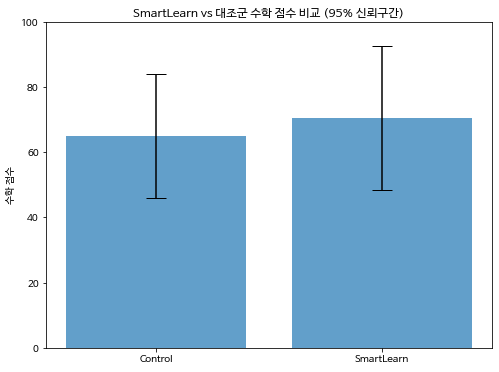

In [11]:
plt.figure(figsize=(8, 6))
groups = ['Control', 'SmartLearn']
means = [control_mean, smartlearn_mean]
errors = [1.96 * control_se, 1.96 * smartlearn_se]
plt.bar(groups, means, yerr=errors, capsize=10, alpha=0.7)
plt.ylabel('수학 점수')
plt.title('SmartLearn vs 대조군 수학 점수 비교 (95% 신뢰구간)')
plt.ylim(0, 100)  # 점수 범위에 맞게 조정
plt.show()


### 5. p-해킹 방지 방안

📋 p-해킹 방지 방안
1. 사전 등록: 연구 계획을 Open Science Framework(OSF)에 등록하여 분석 계획을 투명하게 공개.
2. 다중비교 보정: Bonferroni 또는 FDR 방법을 적용하여 다중 검정으로 인한 오류를 최소화.
3. 독립적 데이터 검증 및 재현성 강화:
분석 결과를 제3자가 동일한 데이터와 코드를 사용하여 재현할 수 있도록 데이터셋과 분석 코드를 공개하고, 독립적인 연구팀을 통해 결과 검증


### 6. 베이즈 인수 계산

In [12]:
# 베이즈 인수 계산 (BIC 기반 근사)
# 대립가설(H1): SmartLearn 효과 있음 vs 귀무가설(H0): 효과 없음
n_total = 2 * n_students
bic_diff = t_stat**2 - np.log(n_total)
bf_10 = np.exp(bic_diff / 2)

print(f"베이즈 인수 (BF₁₀): {bf_10:.2f}")
if bf_10 > 10:
    print("→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)")
elif bf_10 > 3:
    print("→ 중간 증거 (H1 지지: SmartLearn 효과가 있을 가능성 높음)")
elif bf_10 > 1:
    print("→ 약한 증거 (H1 약간 지지)")
elif bf_10 > 0.33:
    print("→ 불분명한 증거 (결론 내리기 어려움)")
elif bf_10 > 0.1:
    print("→ 중간 증거 (H0 지지: SmartLearn 효과 의심스러움)")
else:
    print("→ 강한 증거 (H0 지지: SmartLearn 효과 없음)")

베이즈 인수 (BF₁₀): 1934.97
→ 강한 증거 (H1 지지: SmartLearn 효과가 매우 확실)


### 7. 경영진 보고서 작성

📋 경영진 보고서: SmartLearn 프로그램 효과 검증
==================================================

🎯 핵심 결과
- 대조군 수학 점수: 64.93 ± 9.67
- SmartLearn 수학 점수: 70.47 ± 11.29
- 점수 향상: 5.54 점 (약 [8.53%] 향상)
- 효과크기 (Cohen's d): 0.527
- p-value: 0.00
- 베이즈 인수: 1934.97

##### 💡 비즈니스 결론 및 권장사항:

1. 상용화 추진 및 시장 선점

    SmartLearn은 전통적 학습 방식 대비 **평균 5.54점, 약 8.5%** 의 성적 향상 효과를 보여 과학적으로 효과가 입증되었음.

    경쟁사 출시 전에 전국 단위 상용화의 조속한 추진 및 ‘AI 기반 학습 혁신’이라는 포지셔닝으로 프리미엄 시장 점유율 확보 필요

2. 마케팅 전략

    투자자 미팅에서는 통계적 유의성과 효과 크기, 베이즈 접근을 통한 높은 확신도를 강조하여 기술적 우위를 설명하고,

    학부모 대상 마케팅에서는 “전통 교육 대비 평균 8.5% 향상”과 AI 개인 맞춤 학습의 장점을 구체적 사례와 함께 홍보하여 경쟁 우위 선점

3. 투자 방향

    이번 시범 운영 데이터를 기반으로 장기 추적 연구와 **다른 과목(과학, 영어)** 에 대한 효과 검증을 진행하여 제품 신뢰도 높이기

4. 교육부 보고서 대응

    이번 분석은 p-해킹 방지 조치(사전 분석 계획, 다중비교 보정, 효과 크기 보고 등)를 포함해 학계의 재현성 위기를 고려한 엄격한 방법론을 사용했으며,

    보고서에 평균 차이, 효과 크기, 신뢰구간(95% CI), 베이즈 인수를 포함해 교육부에 제출함으로써 객관적 신뢰도를 강화하였음.

##### ⚠️ 리스크 및 제한사항:

1. 표본 및 지역 제한: 300명, 3개 도시만을 대상으로 해 전국 모든 학생을 대상으로 한 일반화의 어려움

2. 장기 효과 미확인: 6개월 시범 운영이므로 장기적 학습 지속 효과와 대학 입시 성적 반영 여부에 대한 추가 검증 필요

3. 비인지적 영향 미측정: 성적 외에도 학습 흥미, 집중력, 심리적 부담 등 비인지적 요인의 변화 미평가

4. 알고리즘 편향 가능성: AI 추천 시스템의 특정 학습자 그룹에 대한 편향이 있는지 검토 필요

5. 재현성 검증 필요: 다른 연구팀에 의한 독립적 검증이 필요하며, 데이터와 분석 코드를 공개하여 투명성 확보 필요

# 미션 2: 마케팅 캠페인 효과 분석 보고서

In [18]:
np.random.seed(456)
n_customers = 1000
ad_exposure = np.random.binomial(1, 0.6, n_customers)
ages = np.random.randint(20, 60, n_customers)
income = np.random.lognormal(np.log(50000), 0.4, n_customers)
purchase_amount = 100 + 50*ad_exposure + 0.5*ages + 0.0001*income + np.random.normal(0, 20, n_customers)
data_marketing = pd.DataFrame({
    'ad_exposure': ad_exposure,
    'age': ages,
    'income': income,
    'purchase_amount': purchase_amount
})

print("📢 마케팅 데이터 미리보기")
print(data_marketing.groupby('ad_exposure')['purchase_amount'].agg(['count', 'mean', 'std']).round(2))


📢 마케팅 데이터 미리보기
             count    mean    std
ad_exposure                      
0              386  124.60  22.35
1              614  175.32  21.69


### 1. 상관관계 탐색

📊 상관계수 매트릭스
                 ad_exposure    age  income  purchase_amount
ad_exposure            1.000  0.018  -0.050            0.748
age                    0.018  1.000  -0.034            0.203
income                -0.050 -0.034   1.000            0.046
purchase_amount        0.748  0.203   0.046            1.000


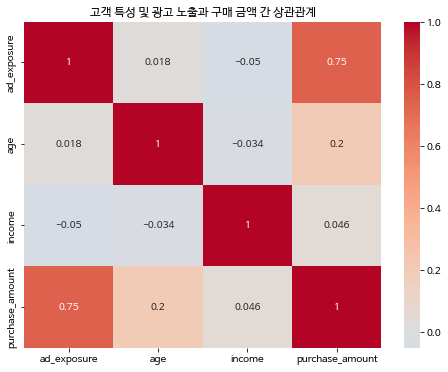

In [19]:
correlation_matrix = data_marketing.corr()
print("📊 상관계수 매트릭스")
print(correlation_matrix.round(3))

# 히트맵으로 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('고객 특성 및 광고 노출과 구매 금액 간 상관관계')
plt.show()


### 2. 단순 비교와 한계

In [21]:
exposed_mean = data_marketing[data_marketing['ad_exposure'] == 1]['purchase_amount'].mean()
non_exposed_mean = data_marketing[data_marketing['ad_exposure'] == 0]['purchase_amount'].mean()
simple_difference = exposed_mean - non_exposed_mean

print(f"광고 노출 그룹 구매 금액: {exposed_mean:.2f}원")
print(f"광고 비노출 그룹 구매 금액: {non_exposed_mean:.2f}원")
print(f"단순 차이: {simple_difference:.2f}원")
print("⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움")
print("   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음")


광고 노출 그룹 구매 금액: 175.32원
광고 비노출 그룹 구매 금액: 124.60원
단순 차이: 50.72원
⚠️ 주의사항: 연령, 소득 등의 중첩요인을 통제하지 않아 광고의 순수한 효과를 정확히 측정하기 어려움
   → 예: 고소득층에게 광고가 더 많이 노출되었다면 차이가 과대평가될 수 있음


### 3. 다중회귀분석

In [32]:
X = data_marketing[['ad_exposure', 'age', 'income']]
y = data_marketing['purchase_amount']
model = LinearRegression()
# 모델 학습 코드 작성
model.fit(X, y)

coeffs = pd.DataFrame({
    '변수': ['광고 노출', '연령', '소득'],
    '계수': model.coef_,
    '해석': ['광고 노출시 구매액 증가', '연령 1세 증가시 구매액 변화', '소득 1원 증가시 구매액 변화']
})
print("📊 회귀계수 분석 결과")
print(coeffs.round(3))
ad_effect = coeffs.loc[coeffs['변수'] == '광고 노출', '계수'].values[0]
print(f"\n🎯 핵심 결과: 광고 효과 = {ad_effect:.2f}원 (다른 조건이 동일할 때)")


📊 회귀계수 분석 결과
      변수      계수                해석
0  광고 노출  50.792     광고 노출시 구매액 증가
1     연령   0.548  연령 1세 증가시 구매액 변화
2     소득   0.000  소득 1원 증가시 구매액 변화

🎯 핵심 결과: 광고 효과 = 50.79원 (다른 조건이 동일할 때)


### 4. 모델 신뢰도 평가

In [33]:
from sklearn.model_selection import cross_val_score, KFold

# 5-폴드 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 교차검증 수행
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')

print(f"5-폴드 교차검증 R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
print(f"모델 설명력: {cv_scores.mean()*100:.1f}% (구매 금액 변동의 약 {cv_scores.mean()*100:.0f}%를 설명)")

if cv_scores.mean() > 0.7:
    print("→ 높은 예측 성능 (신뢰할 만한 모델)")
elif cv_scores.mean() > 0.5:
    print("→ 중간 예측 성능 (참고용으로 활용 가능)")
else:
    print("→ 낮은 예측 성능 (추가 변수 필요)")


5-폴드 교차검증 R²: 0.599 ± 0.024
모델 설명력: 59.9% (구매 금액 변동의 약 60%를 설명)
→ 중간 예측 성능 (참고용으로 활용 가능)


### 5. 인과관계 해석

In [35]:
ad_effect = model.coef_[0]
total_ad_exposed = data_marketing['ad_exposure'].sum()
total_revenue_increase = ad_effect * total_ad_exposed
ad_cost = 200_000_000  # 광고비 2억원
roi = (total_revenue_increase / ad_cost - 1) * 100

print("📋 인과관계 해석 및 ROI 분석")
if ad_effect > 0:
    print(f"✅ 광고는 개인당 구매 금액을 평균 {ad_effect:.2f}원 증가시킵니다.")
    print(f"   총 광고 노출: {total_ad_exposed:,}명")
    print(f"   예상 총 매출 증대: {total_revenue_increase:,.0f}원")
    print(f"   광고 ROI: {roi:.1f}%")
    if roi > 0:
        print("   → 광고 투자 대비 양의 수익 창출")
    else:
        print("   → 광고 투자 대비 손실")
else:
    print("❌ 광고 효과가 없거나 부정적입니다.")

print("\n⚠️ 주의사항:")
print("1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능")
print("2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음")
print("3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요")


📋 인과관계 해석 및 ROI 분석
✅ 광고는 개인당 구매 금액을 평균 50.79원 증가시킵니다.
   총 광고 노출: 614명
   예상 총 매출 증대: 31,186원
   광고 ROI: -100.0%
   → 광고 투자 대비 손실

⚠️ 주의사항:
1. 관찰 데이터 분석이므로 미측정 중첩요인(브랜드 인지도, 계절성 등) 존재 가능
2. 광고의 장기적 효과(브랜드 이미지 개선 등)는 측정되지 않음
3. 무작위 통제 실험이 아니므로 인과관계 해석에 신중함 필요


### 6. 결과 시각화

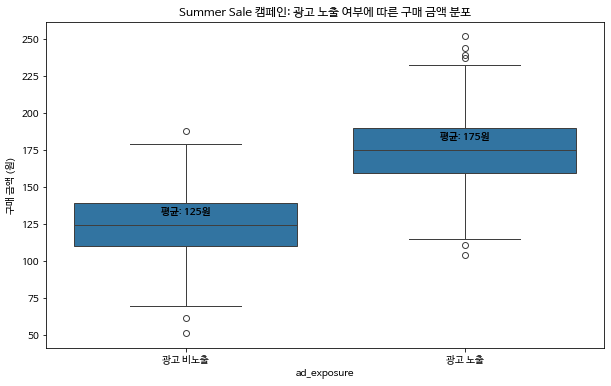

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='ad_exposure', y='purchase_amount', data=data_marketing)
plt.xticks([0, 1], ['광고 비노출', '광고 노출'])
plt.ylabel('구매 금액 (원)')
plt.title('Summer Sale 캠페인: 광고 노출 여부에 따른 구매 금액 분포')

# 평균값 표시
means = data_marketing.groupby('ad_exposure')['purchase_amount'].mean()
for i, mean_val in enumerate(means):
    plt.text(i, mean_val + 5, f'평균: {mean_val:.0f}원', ha='center', va='bottom', fontweight='bold')
plt.show()


### 7. 경영진 보고서 작성

📋 경영진 보고서: Summer Mega Sale 캠페인 효과 분석
==================================================
🎯 핵심 성과 지표
- 광고 노출 그룹 평균 구매 금액: 175.32원
- 광고 비노출 그룹 평균 구매 금액: 124.60원
- 순수 광고 효과 (통제 후): 50.79원
- 모델 설명력 (R²): 59.9%
- 광고 ROI: -100.0%

##### 💡 전략적 권장사항:

1. 추석 캠페인 전략 최적화

    Summer Mega Sale 결과 ROI가 음수로 나타난 만큼, 9월 추석 캠페인에서는 단순 광고 노출보다 구매 전환율이 높은 타겟층(고소득·30~40대)을 중심으로 맞춤형 캠페인을 설계.

2. 예산 재배분

    광고 집행 규모를 20~30% 축소하고, 대신 리타게팅 광고·추천 알고리즘 강화·할인 쿠폰 발급에 예산을 집중.

3. 채널별 성과 기반 타겟팅

    Summer 캠페인에서 상대적으로 높은 클릭률이 확인된 모바일·SNS 광고를 분석하여 추석 캠페인에서는 이 채널에 예산을 집중 투입.

##### ⚠️ 리스크 요소:

- 관찰 데이터의 한계: 실험이 아닌 관찰 데이터 기반이므로 광고 효과에 대한 인과적 추론이 제한적임.

- 장기 효과 미측정: 캠페인 종료 후 재구매율 및 충성 고객 형성 여부에 대한 장기적 영향이 검증되지 않음.

- 시즌성 편향: Summer 시즌 특수 상황(휴가, 세일 경쟁 심화)이 결과에 영향을 미쳤을 수 있어 추석 시즌에 동일한 패턴이 반복되지 않을 가능성 있음.

##### 📅 향후 액션 아이템:

1. A/B 테스트 도입

    추석 캠페인에서는 광고 노출/비노출 무작위 실험을 진행해 광고 효과를 과학적으로 검증.

2. 추가 데이터 수집 및 세분화 분석

    고객 연령, 지역, 구매 패턴 데이터를 추가로 수집하여 세분화된 고객군별 광고 반응 분석 실시.

3. 비용-효과 최적화 모델 구축

    머신러닝 기반의 광고비 지출 대비 매출 예측 모델을 개발해 예산 배분을 데이터 기반으로 최적화.

# 미션 3: 고객 세분화 및 예측 모델링 보고서